In [1]:

import math
import numpy as np
%pip install matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [2]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # does nothing by default (true for a leaf node)
        self._prev = set(_children)
        self._op = _op
        self.label = label 

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad   # This is doing the chain rule to go backwards (remember this is called during '+' only)
            other.grad = 1.0 * out.grad
            
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad # This is doing the chain rule to go backwards (remember this is called during '*' only)
            other.grad = self.data * out.grad
        
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad # chained through local gradient

        out._backward = _backward        
        return out

a= Value(2.0, label='a')
b = Value(-3.0, label='b')
c= Value(10.0, label = 'c')
e = a * b; e.label = 'e'
d= e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [3]:
%pip install graphviz
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

Note: you may need to restart the kernel to use updated packages.


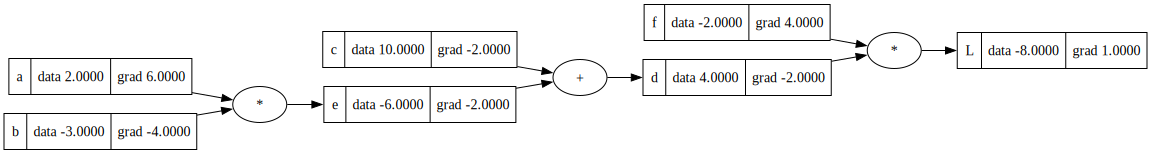

In [4]:
a.grad = 6.0
b.grad = -4.0
c.grad = -2.0
e.grad = -2.0
d.grad = -2.0
f.grad = 4.0
L.grad = 1.0
draw_dot(L)

In [5]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [6]:
def func():

    h = 0.001
    
    a= Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c= Value(10.0, label = 'c')
    e = a * b; e.label = 'e'
    d= e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a= Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c= Value(10.0, label = 'c')
    c.data += h
    e = a * b; e.label = 'e'
    d= e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

func()

-1.9999999999988916


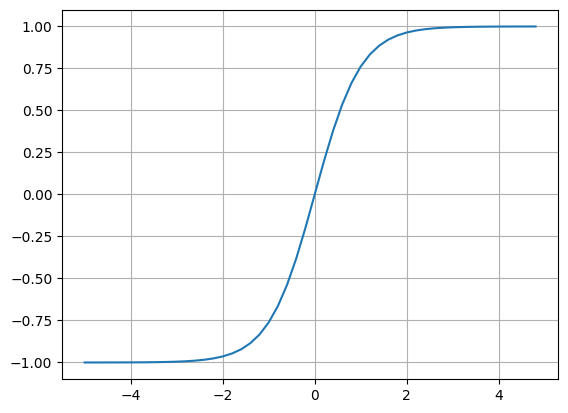

In [7]:
# example two, backprop through a neuron

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [8]:
# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1';
x2w2 = x2*w2; x2w2.label = 'x2*w2';
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2';
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'output' # tan h is a squashing function that moves values between -1 and 1 (kinda)

In [9]:
o.grad = 1.0

In [10]:
# output (o) = tanh(n)
# do/dn = 1 - tanh(n) **2
# do/dn = 1 - o ** 2
# reminder: n.grad = derivative of d(output)/d(n) or do/dn
# n.grad = 1 - o ** 2 = .49999~
n.grad = 0.5

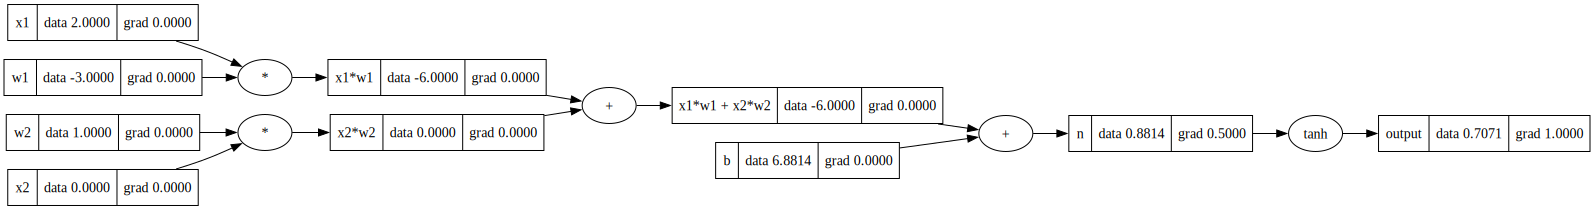

In [11]:
draw_dot(o)

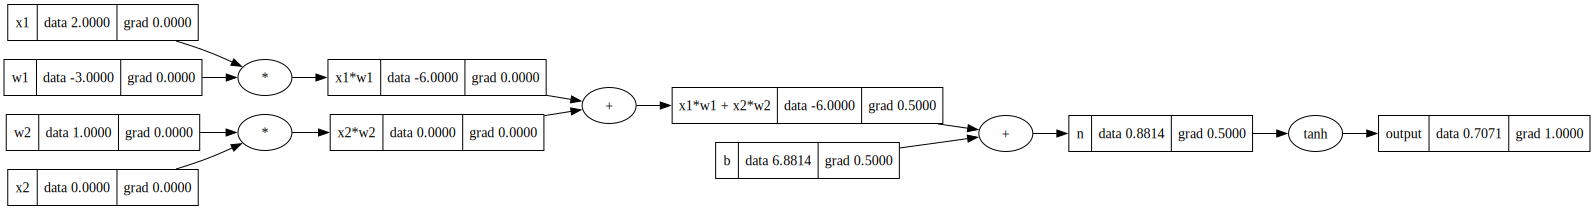

In [12]:
# grad carries through the '+' node, so the grad of the b and w1x1+w2x2 is both the same as n.grad
x1w1x2w2.grad = 0.5
b.grad = 0.5
draw_dot(o)

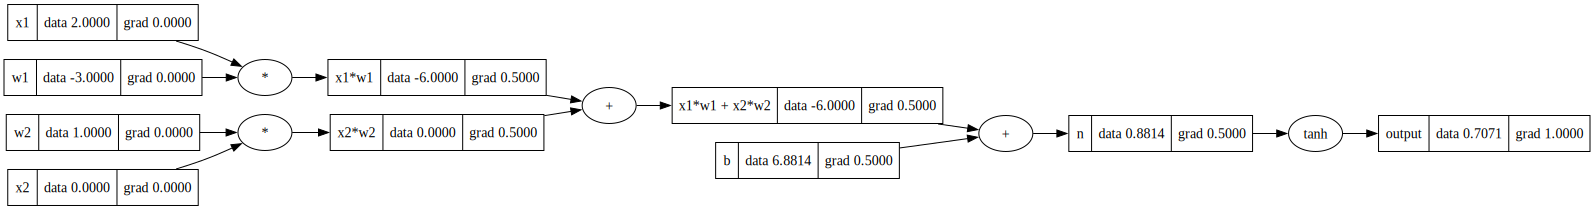

In [13]:
# grad again carried to x1w1 and x2w2
x1w1.grad = 0.5
x2w2.grad = 0.5
draw_dot(o)

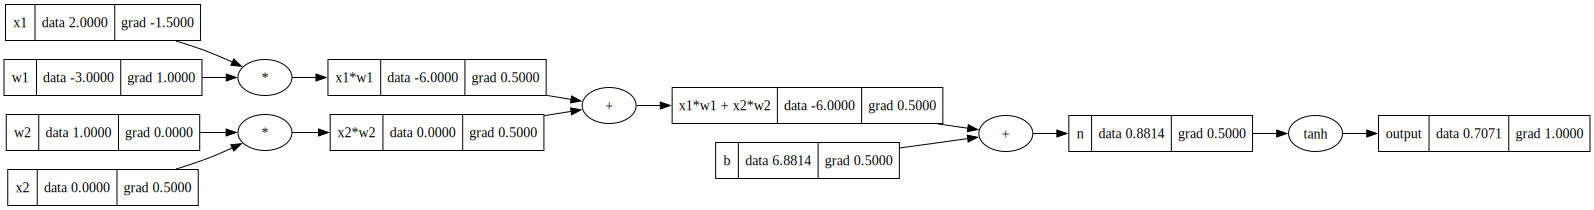

In [14]:
# through derivative proof, finding node.grad for a '*' just means multiplying the resultant grad by the other term data
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

draw_dot(o)

In [15]:
# from this, the following is true:
# # w2 grad is 0 means changing w2 has no impact on the final answer (which makes sense because its being multiplied by x2.data which is zero)
# # x2 grad is not 0 because changing it will actually have an impact on the output

# a positive gradient value means that if the .data goes up, then the output will go up

In [16]:
# now, we will use the 'backward' part of the Value class to do the backwards pass easier


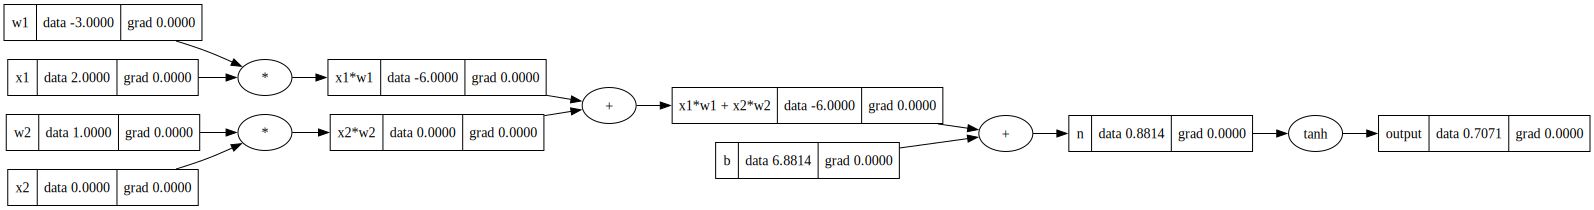

In [17]:
# reset the graph
# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1';
x2w2 = x2*w2; x2w2.label = 'x2*w2';
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2';
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'output'
draw_dot(o)

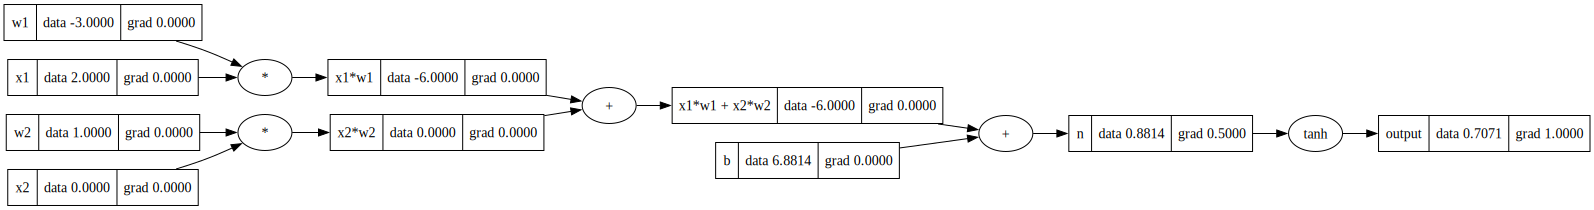

In [18]:
o.grad = 1.0 # default because deriviative of output with respect to output is just 1
o._backward() # this will call the backwards function through Tanh (because going backwards to n goes through tanh)
draw_dot(o) # so now 'n' will have a grad value

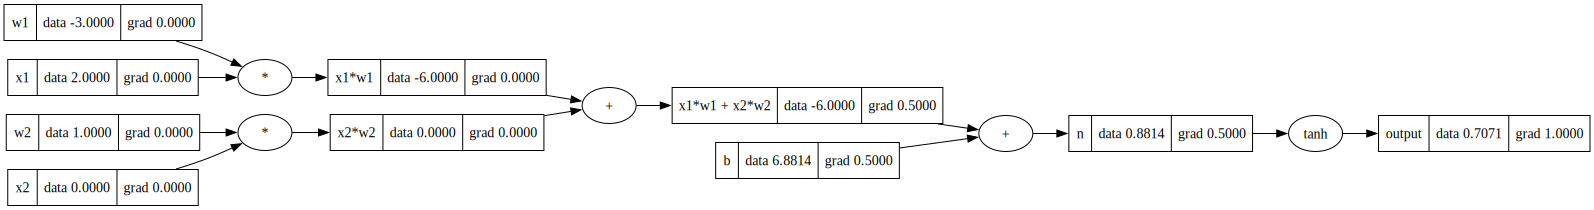

In [19]:
n._backward() # this will now call the backwards func through its prev nodes using the '+' version of backward
draw_dot(o) # so now 'x1*w1 + x2*w2' and 'b' should have grad values (the same as n in this case bc its +)

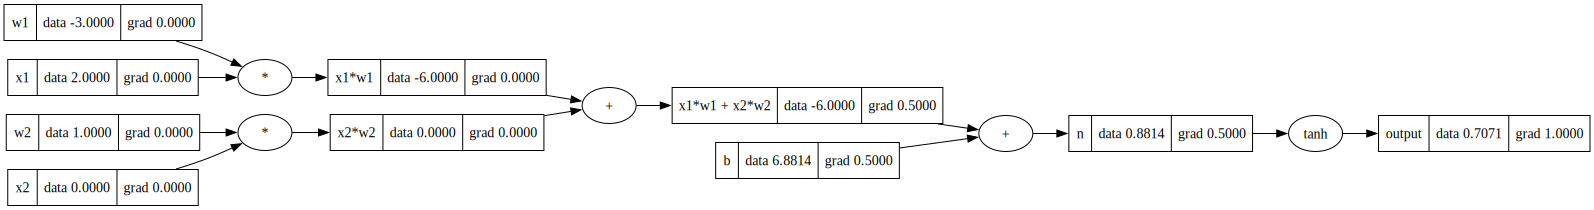

In [20]:
b._backward() #if we try to call backward on a leaf node...
draw_dot(o) # it will change nothing (bc its None by default)

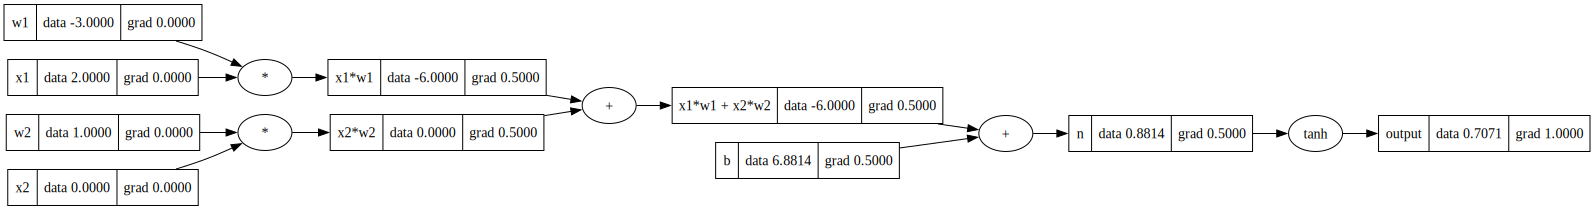

In [21]:
x1w1x2w2._backward() # this will now call the backwards func through its prev nodes using the '+' version of backward
draw_dot(o) # so now 'x2*w2' and 'x1*w1' should have grad values (the same as 'x1*w1 + x2w2' in this case bc its +)

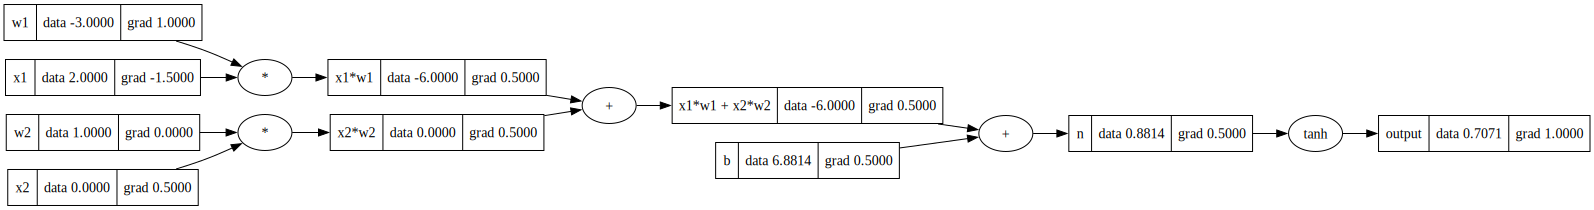

In [22]:
x2w2._backward()
x1w1._backward() # this calls the backward function now using the '*' version of the chain rule (which is w1.grad = other.data * out.grad or in this case w1.grad = 2 * .5 = 1)
draw_dot(o)

In [23]:
# this works fully, but we don't want to have to call backward multiple times

# now, to call all the .backwards in one step, we first need to topologically sort the nodes
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo # this will output the sorted values, notice how .70 (which is o) is last

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

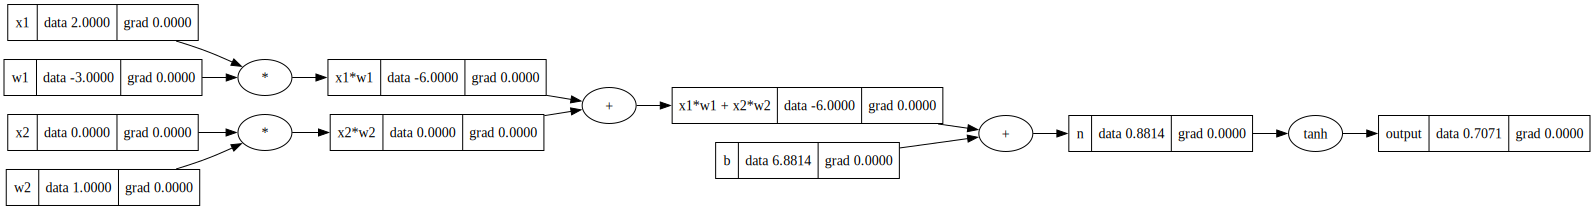

In [24]:
# reset the graph so now we can do it all in one step


# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1';
x2w2 = x2*w2; x2w2.label = 'x2*w2';
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2';
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'output'
draw_dot(o)

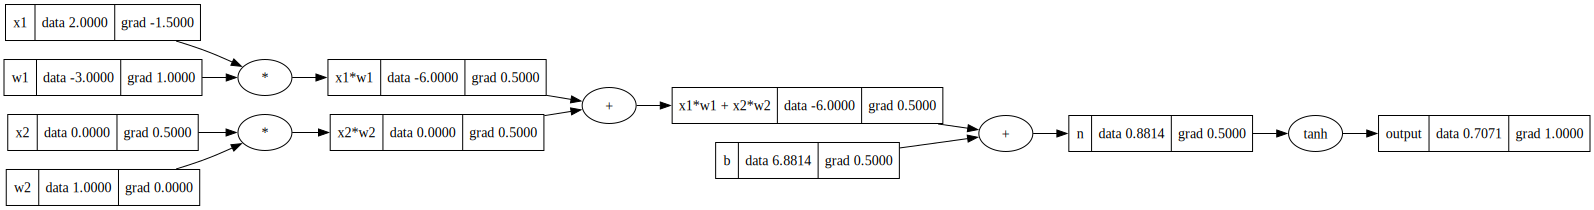

In [25]:
o.grad = 1.0 # inital grad of 1 for self derivative

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo): # in reverse topo order, call backward
    node._backward()

draw_dot(o)

In [26]:
# now, one more time, we fully reset the graph and add the topological sort func to Value class
# this section of the code should work fully on its own (besides the draw graph portion)

In [27]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # does nothing by default (true for a leaf node)
        self._prev = set(_children)
        self._op = _op
        self.label = label 

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # if it gets value, great. if it gets int, change to value
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad   # This is doing the chain rule to go backwards (remember this is called during '+' only)
            other.grad += 1.0 * out.grad
                                            # BUGFIX IN VIDEO 1:25:00: these are now += instead of just = because we should be accumulating the gradients, not just replacing them
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # if it gets value, great. if it gets int, change to value
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad # This is doing the chain rule to go backwards (remember this is called during '*' only)
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out

    def __rmul__(self, other): # covers the case when you try to do '2 * a' which is 2.__mul__(a) so it calls a.__mul__(2) which is handed in mul
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad # chained through local gradient

        out._backward = _backward        
        return out

    def backward(self):  # NEW BACKWARDS FUNCTION IMPLEMENTS FOR REVERSE TOPO SORT
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)
        self.grad = 1.0 # inital grad of 1 for self derivative
        
        for node in reversed(topo): # in reverse topo order, call backward
            node._backward()

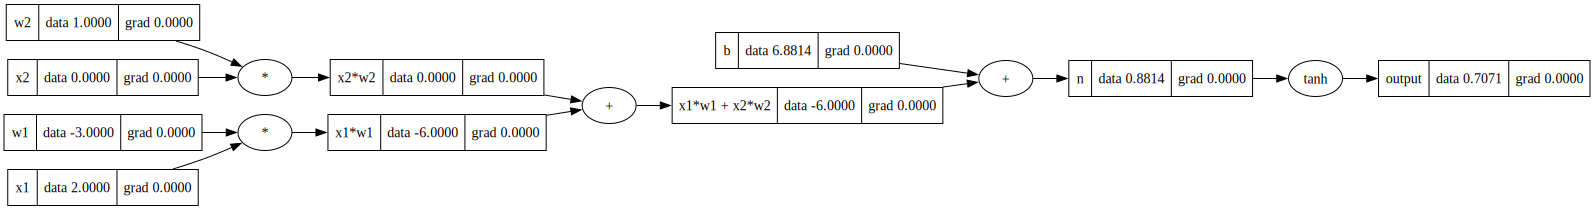

In [28]:
# reset the graph


# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1';
x2w2 = x2*w2; x2w2.label = 'x2*w2';
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2';
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'output'
draw_dot(o)

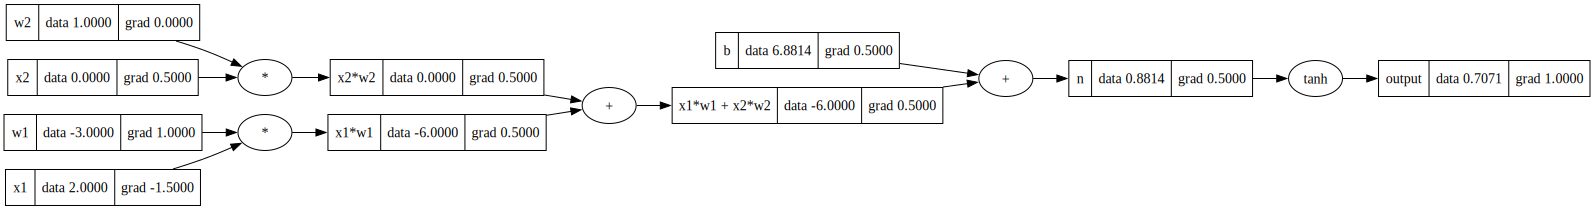

In [29]:
o.backward()
draw_dot(o)

In [30]:
# now, we are looking to expand the tanh function

class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label 

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) 
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad   
            other.grad += 1.0 * out.grad
                                        
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other): 
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad +=  other * (self.data ** (other - 1)) * out.grad    # other * (self.data ** (other - 1)) ==> Power rule, then * out.grad is chain rule
        out._backward = _backward

        return out
    
    def __truediv__(self, other): # self / other
        return self * other ** -1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad 

        out._backward = _backward        
        return out

    def exp(self): # NEW FUNCTION FOR EXPONENTIAL (E TO THE POWER OF X)
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad     # applying chain rule here
        out._backward = _backward

        return out
    
    def backward(self):  
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)
        self.grad = 1.0 
        
        for node in reversed(topo): 
            node._backward()

In [31]:
a= Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [32]:
a= Value(2.0)
b= Value(4.0)
a / b

Value(data=0.5)

In [33]:
a-b

Value(data=-2.0)

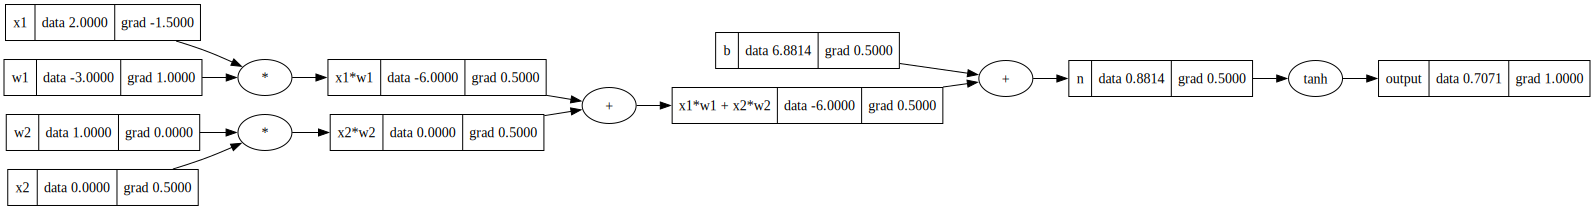

In [34]:
# reset the graph


# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1';
x2w2 = x2*w2; x2w2.label = 'x2*w2';
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2';
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'output'

o.backward()
draw_dot(o)

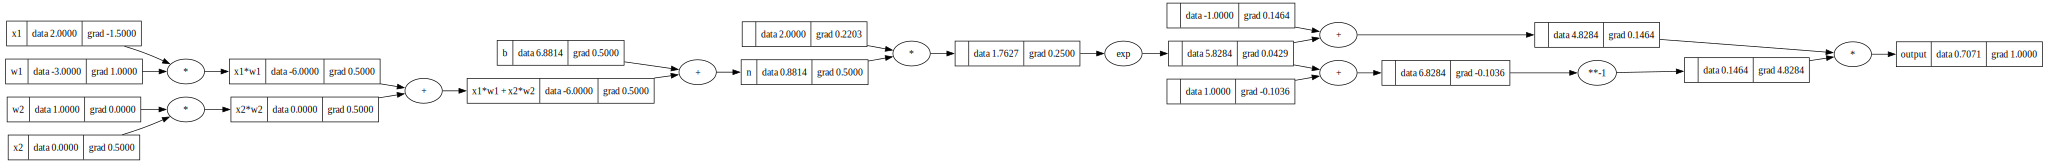

In [35]:
# now do the same thing but expand the hyperbolic tangent


# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1';
x2w2 = x2*w2; x2w2.label = 'x2*w2';
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2';
n = x1w1x2w2 + b; n.label = 'n'

##################
e = (2*n).exp()
o = (e - 1) / (e + 1)
##################
o.label = 'output'

o.backward()
draw_dot(o)

In [36]:
# This is equivalent, but the graph is much longer and expanded to show the formula for tanh (it also supports more operations now)
# This is just done to show that you can support any number of operations or groupings as long as the forward and back passes can be written out

In [37]:
# Now, as an example, we can do the same thing but using pytorch

In [38]:
%pip install torch
import torch

Note: you may need to restart the kernel to use updated packages.


In [39]:
x1 = torch.Tensor([2.0]).double()                  ; x1.requires_grad = True    # A tensor is just a n-dimensional array of scalar values
x2 = torch.Tensor([0.0]).double()                  ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                 ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                  ; w2.requires_grad = True    # the .double makes it a float64 instead of float32
b = torch.Tensor([6.8813735970795432]).double()    ; b.requires_grad = True     # because these are leaf nodes, torch assumes they don't need grad, so we have to manually set it
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

test = torch.Tensor([[1,2,3], [4,5,6]]) # for example, this tensor is an array of scalar values
print(test)
print(test.shape)
print(o)
print(o.item())
print(x2)
print(x2.grad) # gives all the same outputs as micrograd
x2.grad.item()

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
tensor([[1., 2., 3.],
        [4., 5., 6.]])
torch.Size([2, 3])
tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
0.7071066904050358
tensor([0.], dtype=torch.float64, requires_grad=True)
tensor([0.5000], dtype=torch.float64)


0.5000001283844369

In [40]:
#######################################################################################################################
# Now, time to make the neual network using our micrograd Values

In [41]:
class Neuron:

    def __init__(self, num_inputs):
        self.weight = [Value(random.uniform(-1, 1)) for _ in range(num_inputs)]
        self.bias = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # weight * x + bias  (where * is the dot product)
        weight_and_data = zip(self.weight, x) # zip takes two iterators and creates a new iterator that iteratoes over tuple (basically pairs up two lists)
        raw_activation = sum((wi*xi for wi, xi in weight_and_data), self.bias)
        out = raw_activation.tanh()
        return out

    def parameters(self):
        return self.weight + [self.bias]

x = [2.0, 3.0] # vector of data
n = Neuron(2) # meaning 2 dimensional neuron
n(x) # calls __call__

Value(data=0.9717033679103867)

In [42]:
class Layer:

    def __init__(self, num_inputs, num_outputs):
        self.neurons = [Neuron(num_inputs) for _ in range (num_outputs)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

x = [2.0, 3.0] # vector of data
n = Layer(2, 3) # 2 -> how many dimensions for the neuron, 3 -> how many neurons in the layer
n(x) #__call__

[Value(data=0.7038379134453714),
 Value(data=0.9574133096332706),
 Value(data=0.9989341734882382)]

In [43]:
# now we will make a full multilayer perceptron

class MLP:

    def __init__(self, num_inputs, list_num_outputs): # num_inputs -> how many dimensions each neuron has, list_num_outputs -> a list of how many neurons each layer has (ex: 2, 3, 2)
        sz = [num_inputs] + list_num_outputs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(list_num_outputs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# for example, to make a NN with 1 input layer with 3 neurons, 2 hidden layers with 4 neurons each, and an output layer with 1 neuron:
x = [2.0, 3.0, -1.0] # this is the input neurons
n = MLP(3, [4, 4, 1]) # 3 dimensional, 2 hidden layers and 1 output layer
n(x) # this will print the value of the forward pass

Value(data=0.34972017107392656)

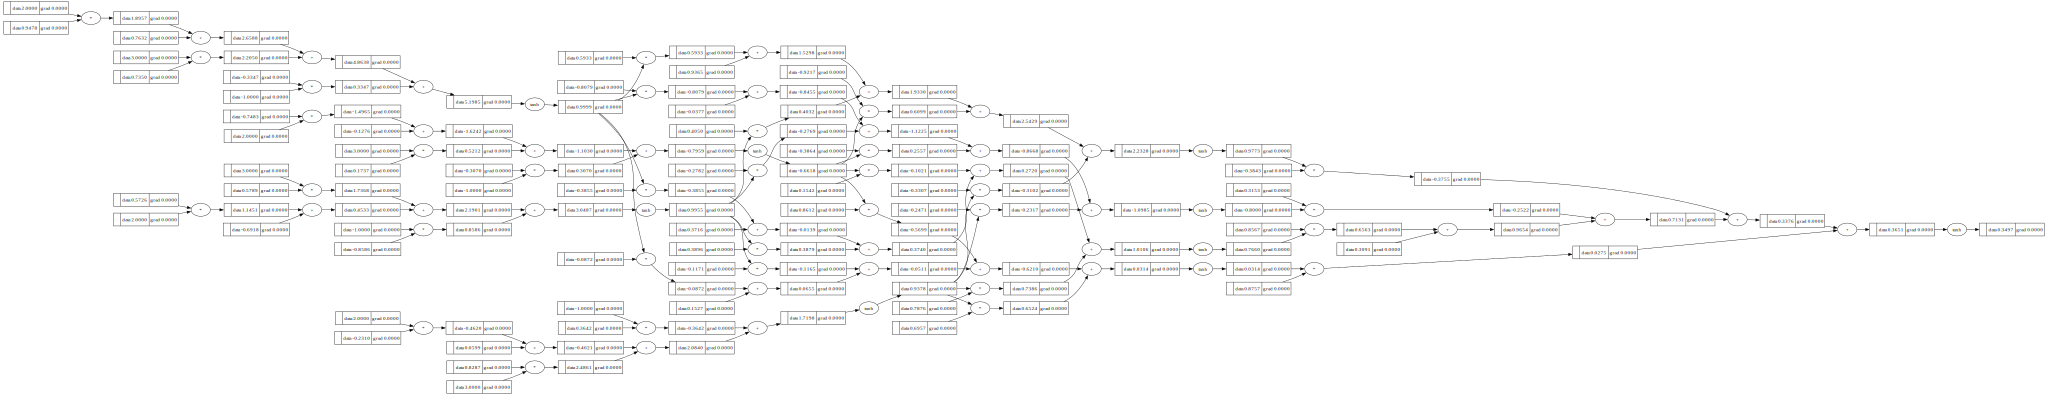

In [44]:
# now we can draw the entire MLP
draw_dot(n(x))

In [45]:
# creating a simple dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets, so when fed [2.0,3.0,-1.0] it should output 1.0, and so on down the list (binary classifier neural net)

In [46]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.34972017107392656),
 Value(data=-0.9059666506458816),
 Value(data=0.25599153586513756),
 Value(data=-0.05319248377897452)]

In [47]:
# here we can see the baseline guesses, we can see that the first one is too low and needs to go up, the second one needs to go lower, third needs lower, and last needs higher

In [48]:
# so we now need to tune the weights

In [49]:
# we do this by calculating a single number to determine accuracy (loss)

In [50]:
[(yout - ygt) **2 for ygt, yout in zip(ys, ypred)] # taking the prediction & the ground truth (aka desired target) and subtracting them, then squaring it. And doing this for each set of ys, ypred

[Value(data=0.42286385590812325),
 Value(data=0.008842270790753688),
 Value(data=1.5775147381648669),
 Value(data=1.1092144078885255)]

In [51]:
# ((I think these are the root mean square error values))
# we square it so that its positive as a range between what we expected vs what we wanted
# when the prediction is exactly right, this value will be zero

In [52]:
# to get the final loss, we just sum them
loss = sum((yout - ygt) **2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.1184352727522695)

In [53]:
# (the lower the loss number, the better)

In [54]:
loss.backward() # now we backprop!

In [55]:
# and now we can see the new grad value on the original weights
n.layers[0].neurons[0].weight[0].grad # the grad value of the first weight of the first neuron of the first layer

-0.08342867576101291

In [56]:
#draw_dot(loss) this is huge, but ends with the value of loss

In [57]:
len(n.parameters()) # there are 41 parameters within the NN

41

In [58]:
n.layers[0].neurons[0].weight[0].data # now we will change this slightly

0.9478384306968504

In [59]:
step_size = -0.01 # negative because we want to minimize loss, so if grad is negative we should add, and if its positive we should subtract

for p in n.parameters():
    p.data += step_size * p.grad

In [60]:
n.layers[0].neurons[0].weight[0].data # should be slightly shifted

0.9486727174544605

In [61]:
# Remember, the direction of the shift is based on the value of the GRAD not the DATA

In [62]:
# now, we recalculate loss and should see that it goes down from the previous print
ypred = [n(x) for x in xs]
loss = sum((yout - ygt) **2 for ygt, yout in zip(ys, ypred))
loss

Value(data=2.5585015286464756)

In [63]:
# now, do it again
for p in n.parameters():
        p.grad = 0.0
loss.backward() #backprop

for p in n.parameters():
    p.data += step_size * p.grad #adjust based on new grad values

ypred = [n(x) for x in xs]
loss = sum((yout - ygt) **2 for ygt, yout in zip(ys, ypred)) # calculate new loss
loss

Value(data=2.2009196573405054)

In [64]:
# this iterative process is gradient descent of loss

In [65]:
# this works, now we redo the code with looping built in

In [66]:
# creating a simple dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [67]:
# Gradient Descent
for k in range (100):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) **2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward() 

    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 2.2009196573405054
1 0.9474324950925872
2 0.4609560399008884
3 0.2700802252127145
4 0.18879341866790833
5 0.14702395159789855
6 0.12002660836258545
7 0.10120704810684444
8 0.08736957187157562
9 0.07678405934445144
10 0.06843466137099294
11 0.06168674479059292
12 0.05612392861199447
13 0.05146196719465365
14 0.04750034481304865
15 0.04409365348400754
16 0.041133936404948626
17 0.03853939711382563
18 0.036246952586586806
19 0.034207187779628515
20 0.03238085559510694
21 0.030736397681372714
22 0.02924815534219532
23 0.027895056723879298
24 0.02665963887206234
25 0.025527309223502555
26 0.02448578092885976
27 0.023524636147337775
28 0.022634984762059905
29 0.021809195084547005
30 0.02104067946182589
31 0.020323722176941807
32 0.019653340234149386
33 0.019025169935620576
34 0.018435373850697323
35 0.01788056403129451
36 0.017357738262233892
37 0.016864226839911484
38 0.0163976479081895
39 0.015955869790667973
40 0.01553697907521227
41 0.015139253452891754
42 0.014761138506291176
43 0.014

In [68]:
ypred

[Value(data=0.9702143229833673),
 Value(data=-0.9835588178600871),
 Value(data=-0.9497795550068076),
 Value(data=0.9513049710703991)]

In [69]:
# Success! It has correctly guessed 1, -1, -1, 1